# Advantages of using PCA for classification

One of the most important applications of PCA is for speeding up machine learning algorithms. The MNIST database of handwritten digits is more suitable as it has 784 feature columns (784 dimensions).

## Download the Data
You can also add a data_home parameter to fetch_mldata to change where you download the data.

In [1]:
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original')

The images that you downloaded are contained in mnist.data and has a shape of (70000, 784) meaning there are 70,000 images with 784 dimensions (784 features).

The labels (the integers 0–9) are contained in mnist.target. The features are 784 dimensional (28 x 28 images) and the labels are simply numbers from 0–9.

## Split Data into Training and Test Sets
Typically the train test split is 80% training and 20% test. This gives a training set of 56,000 examples, and a test set of 14,000 examples.

In [2]:
from sklearn.model_selection import train_test_split

train_img, test_img, train_lbl, test_lbl = train_test_split(mnist.data, mnist.target, test_size=0.2, random_state=0)

print('The size of the training data set:', train_img.shape)
print('The size of the test data set:', test_img.shape)

The size of the training data set: (56000, 784)
The size of the test data set: (14000, 784)


## Standardize the Data
PCA is effected by scale so you need to scale the features in the data before applying it. You can transform the data onto unit scale (mean = 0 and variance = 1) which is a requirement for the optimal performance of some machine learning algorithms. StandardScaler helps standardize the dataset features. Note you fit on the training set and transform on the training and test set. 

In [10]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
# Fit on training set only.
scaler.fit(train_img)
# Apply transform to both the training set and the test set.
train_img = scaler.transform(train_img)
test_img = scaler.transform(test_img)

## Import and apply PCA
The following code below aims to retained 90% of the variance. It means that pca algorithm chooses the minimum number of principal components such that 90% of the variance is retained.

In [4]:
from sklearn.decomposition import PCA
# Make an instance of the Model
pca = PCA(0.9)

# Fitting PCA on the training set only
pca.fit(train_img)

PCA(copy=True, iterated_power='auto', n_components=0.9, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

Note: You can find out how many components PCA have been selected after fitting the model using ``pca.n_components_`` function:

In [5]:
pca.n_components_

235

In this case, 90% of the variance amounts to 235 principal components.

## Apply the mapping (transform) to both the training set and the test set.

In [6]:
train_img = pca.transform(train_img)
test_img = pca.transform(test_img)

## Image reconstruction from compressed representation
Indeed, PCA compresses high dimensional data to lower dimensional data. It can also take the compressed representation of the data (lower dimensional data) back to an approximation of the original high dimensional data. 

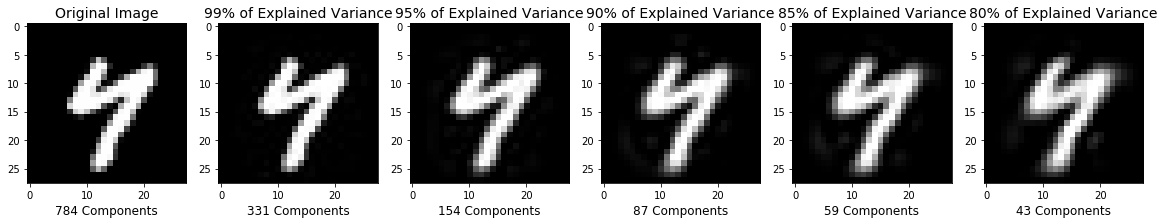

In [11]:
import matplotlib.pyplot as plt

def compressedImage(percentage, images): 
    # percentage should be a decimal from 0 to 1 
    pca = PCA(percentage)
    pca.fit(images)
    components = pca.transform(images)
    approxOriginal = pca.inverse_transform(components)
    return approxOriginal, pca.n_components_, 100*percentage

explainedVariance = [1, 0.99, 0.95, 0.9, 0.85, 0.8]
image = 28500

plt.figure(figsize=(20,4));
for i in range(len(explainedVariance)):
    plt.subplot(1, len(explainedVariance), i+1);
    if explainedVariance[i]==1:
        plt.imshow(mnist.data[image].reshape(28,28),
                   cmap = plt.cm.gray, interpolation='nearest',
                   clim=(0, 255));
        plt.xlabel("%d"% mnist.data.shape[1]+' Components', fontsize = 12)
        plt.title('Original Image', fontsize = 14)
    else: 
        compimage = compressedImage(explainedVariance[i], mnist.data)
        plt.imshow(compimage[0][image].reshape(28, 28),
                   cmap = plt.cm.gray, interpolation='nearest',
                   clim=(0, 255));
        plt.xlabel("%d"% compimage[1]+' Components', fontsize = 12)
        plt.title("%d"% compimage[2]+'% of Explained Variance', fontsize = 14)
plt.show()

## Timing of applying Logistic Regression to the PCA-based transformed Data

The aim of this tutorial section was to show that you can use PCA to speed up the fitting of machine learning algorithms. The table below shows how long it took to fit logistic regression on my computer after applying PCA (retaining different amounts of variance each time).

In [9]:
from sklearn.linear_model import LogisticRegression
import pandas as pd
import time

train_img, test_img, train_lbl, test_lbl = train_test_split(mnist.data, mnist.target, test_size=0.2, random_state=0)

scaler = StandardScaler()
# Fit on training set only.
scaler.fit(train_img)
# Apply transform to both the training set and the test set.
train_img = scaler.transform(train_img)
test_img = scaler.transform(test_img)


# Create table to compare the used metrics
table_columns = ['Explained Variance (%)', 'Number of PCs', 'Accuracy','Elapsed Time (s)']
timing = pd.DataFrame(columns = table_columns)

explainedVariance = [1, 0.99, 0.95, 0.9, 0.85, 0.8]
#explainedVariance = [1, 0.99]

#index through explained variance
row_index = 0

for i in range(len(explainedVariance)):
    if explainedVariance[i]==1:
        t = time.process_time()
        logisticRegr = LogisticRegression(solver = 'lbfgs')
        logisticRegr.fit(train_img, train_lbl)
        accuracy = logisticRegr.score(test_img, test_lbl)
        elapsed_time = time.process_time() - t
        timing.loc[row_index, 'Explained Variance (%)'] = explainedVariance[i]*100
        timing.loc[row_index, 'Number of PCs'] = train_img.shape[1]
        timing.loc[row_index, 'Accuracy'] = accuracy
        timing.loc[row_index, 'Elapsed Time (s)'] = elapsed_time
        row_index+=1
    else:
        # Make an instance of the Model
        pca = PCA(explainedVariance[i])
        # Fitting PCA on the training set only
        pca.fit(train_img)
        t = time.process_time()
        logisticRegr = LogisticRegression(solver = 'lbfgs')
        logisticRegr.fit(pca.transform(train_img), train_lbl)
        accuracy = logisticRegr.score(pca.transform(test_img), test_lbl)
        elapsed_time = time.process_time() - t
        timing.loc[row_index, 'Explained Variance (%)'] = explainedVariance[i]*100
        timing.loc[row_index, 'Number of PCs'] = pca.n_components_
        timing.loc[row_index, 'Accuracy'] = accuracy
        timing.loc[row_index, 'Elapsed Time (s)'] = elapsed_time
        row_index+=1
        
timing

,Explained Variance (%),Number of PCs,Accuracy,Elapsed Time (s)
0,100,784,0.915857,204.859
1,99,541,0.917357,150.641
2,95,330,0.918429,97.1562
3,90,235,0.917286,73.5781
4,85,183,0.916143,60.1875
5,80,147,0.913929,51.9062


As you can see, by reducing the selected number of principal components, the Logistic Regression machine learning algorithm is much faster. At the same time, its classification accuracy is sometimes better based on a reduced number of principal components.